In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from src.dataset import *
from src.concept_vectors import *
from src.util import *
from src.plots import *
from src.hierarchy import *
from src.metrics import *
from src.models import * 
from src.create_vectors import *

2024-03-27 13:26:58.511987: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageOps
import pickle
import sklearn
import pandas as pd
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from scipy.spatial.distance import cdist
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
from PIL import Image


## Concept Correlations

In [22]:
baseline_colors = {}

for i in range(10):
    all_files = glob.glob("../../datasets/colored_mnist/images/{}/*.png".format(i))
    image = Image.open(all_files[0])
    image_array = np.array(image)
    all_colors = [image_array[i,j] for i in range(28) for j in range(28) if np.sum(image_array[i,j]) != 0][0]
    baseline_colors[i] = list(all_colors)

In [23]:
baseline_colors

{0: [249, 46, 71],
 1: [20, 134, 108],
 2: [249, 183, 40],
 3: [13, 119, 199],
 4: [24, 154, 136],
 5: [191, 66, 193],
 6: [9, 183, 218],
 7: [157, 193, 140],
 8: [239, 24, 119],
 9: [148, 30, 27]}

In [24]:
def replace_pixels(img_pixel,num,correlation_rate):
    if random.random() < correlation_rate:
        curr_color = baseline_colors[num]
    else:
        all_other_nums = [i for i in range(10) if i!=num]
        rand_num = random.sample(all_other_nums,1)[0]
        curr_color = baseline_colors[rand_num]
    
    for i in range(len(img_pixel)):
        for j in range(len(img_pixel[0])):
            if np.sum(img_pixel[i][j]) != 0:
                img_pixel[i,j] = np.array(curr_color)
    return Image.fromarray(img_pixel)

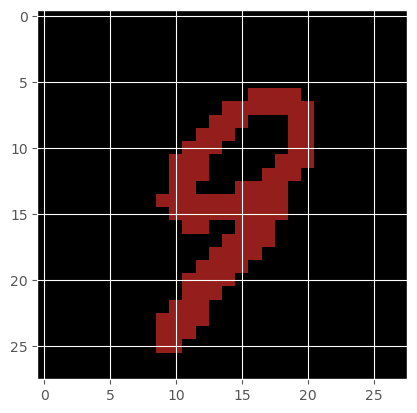

In [25]:
# Display the image using imshow
plt.imshow(replace_pixels(image_array,9,0.5))
plt.show()


## OIS

In [5]:
dataset = MNIST_Dataset()
attributes = dataset.get_attributes() 
suffix = "" 
seed = 43

In [6]:
def concept_purity_matrix(
    c_soft,
    c_true,
    concept_label_cardinality=None,
    predictor_model_fn=None,
    predictor_train_kwags=None,
    test_size=0.2,
    ignore_diags=False,
    jointly_learnt=False,
):
    """
    Computes a concept purity matrix where the (i,j)-th entry represents the
    predictive accuracy of a classifier trained to use the i-th concept's soft
    labels (as given by c_soft_train) to predict the ground truth value of the
    j-th concept.

    This process is informally defined only for binary concepts by Mahinpei et
    al.'s in "Promises and Pitfalls of Black-Box Concept Learning Models".
    Nevertheless, this method supports both binary concepts (given as a 2D
    matrix in c_soft) or categorical concepts (given by a list of 2D matrices
    in argument c_soft).

    :param Or[np.ndarray, List[np.ndarray]] c_soft: Predicted set of "soft"
        concept representations by a concept encoder model applied to the
        testing data. This argument must be an np.ndarray with shape
        (n_samples, ..., n_concepts) where the concept representation may be
        of any rank as long as the last dimension is the dimension used to
        separate distinct concept representations. If concepts have distinct
        array shapes for their representations, then this argument is expected
        to be a list of `n_concepts` np.ndarrays where the i-th element in the
        list is an array with shape (n_samples, ...) containing the tensor
        representation of the i-th concept.
        Note that in either case we only require that the first dimension.
    :param np.ndarray c_true: Ground truth concept values in one-to-one
        correspondence with concepts in c_soft. Shape must be
        (n_samples, n_concepts).
    :param List[int] concept_label_cardinality: If given, then this is a list
        of integers such that its i-th index contains the number of classes
        that the it-th concept may take. If not given, then we will assume that
        all concepts have the same cardinality as the number of activations in
        their soft representations.
    :param Function[(int, int), sklearn-like Estimator] predictor_model_fn: A
        function generator that takes as an argument two values, the number of
        classes for the input concept and the number of classes for the output
        target concept, respectively, and produces an sklearn-like Estimator
        which one can train for predicting a concept given another concept's
        soft concept values. If not given then we will use a 3-layer ReLU MLP
        as our predictor.
    :param Dict[Any, Any] predictor_train_kwags: optional arguments to pass
        the estimator being when calling its `fit` method.
    :param float test_size: A value in [0, 1] indicating the fraction of the
        given data that will be used to evaluate the trained concept-based
        classifier. The rest of the data will be used for training said
        classifier.

    :return np.ndarray: a matrix with shape (n_concepts, n_concepts)
        where the (i,j)-th entry specifies the testing AUC of using the i-th
        concept soft representations to predict the j-th concept.
    """
    # Start by handling default arguments
    predictor_train_kwags = predictor_train_kwags or {}

    # Check that their rank is the expected one
    assert len(c_true.shape) == 2, (
        f'Expected testing concept predictions to be a matrix with shape '
        f'(n_samples, n_concepts) but instead got a matrix with shape '
        f'{c_true.shape}'
    )

    # Construct a list concept_label_cardinality that maps a concept to the
    # cardinality of its label set as specified by the testing data
    (n_samples, n_true_concepts) = c_true.shape
    if isinstance(c_soft, np.ndarray):
        n_soft_concepts = c_soft.shape[-1]
    else:
        assert isinstance(c_soft, list), (
            f'c_soft must be passed as either a list or a np.ndarray. '
            f'Instead we got an instance of "{type(c_soft).__name__}".'
        )
        n_soft_concepts = len(c_soft)

    assert n_soft_concepts >= n_true_concepts, (
        f'Expected at least as many soft concept representations as true '
        f'concepts labels. However we received {n_soft_concepts} soft concept '
        f'representations per sample while we have {n_true_concepts} true '
        f'concept labels per sample.'
    )

    if isinstance(c_soft, np.ndarray):
        # Then, all concepts must have the same representation size
        assert c_soft.shape[0] == c_true.shape[0], (
            f'Expected a many test soft-concepts as ground truth test '
            f'concepts. Instead got {c_soft.shape[0]} soft-concepts '
            f'and {c_true.shape[0]} ground truth test concepts.'
        )
        if concept_label_cardinality is None:
            concept_label_cardinality = [2 for _ in range(n_soft_concepts)]
        # And for simplicity and consistency, we will rewrite c_soft as a
        # list such that i-th entry contains an array with shape
        # (n_samples, repr_size) indicating the representation of the i-th
        # concept for all samples
        new_c_soft = [None for _ in range(n_soft_concepts)]
        for i in range(n_soft_concepts):
            if len(c_soft.shape) == 1:
                # If it is a scalar representation, then let's make it explicit
                new_c_soft[i] = np.expand_dims(c_soft[..., i], axis=-1)
            else:
                new_c_soft[i] = c_soft[..., i]
        c_soft = new_c_soft
    else:
        # Else, time to infer these values from the given list of soft
        # labels
        assert isinstance(c_soft, list), (
            f'c_soft must be passed as either a list or a np.ndarray. '
            f'Instead we got an instance of "{type(c_soft).__name__}".'
        )
        if concept_label_cardinality is None:
            concept_label_cardinality = [None for _ in range(n_soft_concepts)]
            for i, soft_labels in enumerate(c_soft):
                concept_label_cardinality[i] = max(soft_labels.shape[-1], 2)
                assert soft_labels.shape[0] == c_true.shape[0], (
                    f"For concept {i}'s soft labels, we expected "
                    f"{c_true.shape[0]} samples as we were given that many "
                    f"in the ground-truth array. Instead we found "
                    f"{soft_labels.shape[0]} samples."
                )

    # Handle the default parameters for both the generating function and
    # the concept label cardinality
    if predictor_model_fn is None:
        # Then by default we will use a simple MLP classifier with one hidden
        # ReLU layer with 32 units in it
        def predictor_model_fn(
            output_concept_classes=2,
        ):
            estimator = tf.keras.models.Sequential([
                tf.keras.layers.Dense(
                    32,
                    activation='relu',
                    name="predictor_fc_1",
                ),
                tf.keras.layers.Dense(
                    output_concept_classes if output_concept_classes > 2 else 1,
                    # We will merge the activation into the loss for numerical
                    # stability
                    activation=None,
                    name="predictor_fc_out",
                ),
            ])
            if jointly_learnt:
                loss = tf.nn.sigmoid_cross_entropy_with_logits
            else:
                loss = (
                    tf.keras.losses.SparseCategoricalCrossentropy(
                        from_logits=True
                    ) if output_concept_classes > 2 else
                    tf.keras.losses.BinaryCrossentropy(
                        from_logits=True,
                    )
                )
            estimator.compile(
                # Use ADAM optimizer by default
                optimizer='adam',
                # Note: we assume labels come without a one-hot-encoding in the
                #       case when the concepts are categorical.
                loss=loss,
            )
            return estimator

    predictor_train_kwags = predictor_train_kwags or {
        'epochs': 25,
        'batch_size': min(512, n_samples),
        'verbose': 0,
    }

    # Time to start formulating our resulting matrix
    result = np.zeros((n_soft_concepts, n_true_concepts), dtype=np.float32)

    # Split our test data into two subsets as we will need to train
    # a classifier and then use that trained classifier in the remainder of the
    # data for computing our scores
    train_indexes, test_indexes = train_test_split(
        list(range(n_samples)),
        test_size=test_size,
    )

    for src_soft_concept in tqdm(range(n_soft_concepts)):

        # Construct a test and training set of features for this concept
        concept_soft_train_x = c_soft[src_soft_concept][train_indexes, ...]
        concept_soft_test_x = c_soft[src_soft_concept][test_indexes, ...]
        if len(concept_soft_train_x.shape) == 1:
            concept_soft_train_x = tf.expand_dims(
                concept_soft_train_x,
                axis=-1,
            )
            concept_soft_test_x = tf.expand_dims(
                concept_soft_test_x,
                axis=-1,
            )
        if jointly_learnt:
            # Construct a new estimator for performing this prediction
            output_size = 0
            for tgt_true_concept in range(n_true_concepts):
                output_size += (
                    concept_label_cardinality[tgt_true_concept]
                    if concept_label_cardinality[tgt_true_concept] > 2
                    else 1
                )
            estimator = predictor_model_fn(output_size)
            # Train it
            estimator.fit(
                concept_soft_train_x,
                c_true[train_indexes, :],
                **predictor_train_kwags,
            )
            # Compute the AUC of this classifier on the test data
            preds = estimator.predict(concept_soft_test_x)
            for tgt_true_concept in range(n_true_concepts):
                true_concepts = c_true[test_indexes, tgt_true_concept]
                used_preds = preds[:, tgt_true_concept]
                if concept_label_cardinality[tgt_true_concept] > 2:
                    # Then lets apply a softmax activation over all the probability
                    # classes
                    used_preds = scipy.special.softmax(used_preds, axis=-1)

                    # And make sure we only compute the AUC of labels that are
                    # actually used
                    used_labels = np.sort(np.unique(true_concepts))

                    # And select just the labels that are in fact being used
                    true_concepts = tf.keras.utils.to_categorical(
                        true_concepts,
                        num_classes=concept_label_cardinality[tgt_true_concept],
                    )[:, used_labels]
                    used_preds = used_preds[:, used_labels]
                if len(np.unique(true_concepts)) > 1:
                    auc = sklearn.metrics.roc_auc_score(
                        true_concepts,
                        used_preds,
                        multi_class='ovo',
                    )
                else:
                    if concept_label_cardinality[tgt_true_concept] <= 2:
                        used_preds = (
                            scipy.special.expit(used_preds) >= 0.5
                        ).astype(np.int32)
                    else:
                        used_preds = np.argmax(used_preds, axis=-1)
                        true_concepts = np.argmax(true_concepts, axis=-1)
                    auc = sklearn.metrics.accuracy_score(
                        true_concepts,
                        used_preds,
                    )

                # Finally, time to populate the actual entry of our resulting
                # matrix
                result[src_soft_concept, tgt_true_concept] = auc
        else:
            for tgt_true_concept in range(n_true_concepts):
                # Let's populate the (i,j)-th entry of our matrix by first
                # training a classifier to predict the ground truth value of
                # concept j using the soft-concept labels for concept i.
                if ignore_diags and (src_soft_concept == tgt_true_concept):
                    # Then for simplicity sake we will simply set this to one
                    # as it is expected to be perfectly predictable
                    result[src_soft_concept, tgt_true_concept] = 1
                    continue

                # Construct a new estimator for performing this prediction
                estimator = predictor_model_fn(
                    concept_label_cardinality[tgt_true_concept]
                )
                # Train it
                estimator.fit(
                    concept_soft_train_x,
                    c_true[train_indexes, tgt_true_concept:(tgt_true_concept + 1)],
                    **predictor_train_kwags,
                )

                # Compute the AUC of this classifier on the test data
                preds = estimator.predict(concept_soft_test_x)
                true_concepts = c_true[test_indexes, tgt_true_concept]
                if concept_label_cardinality[tgt_true_concept] > 2:
                    # Then lets apply a softmax activation over all the
                    # probability classes
                    preds = scipy.special.softmax(preds, axis=-1)

                    # And make sure we only compute the AUC of labels that are
                    # actually used
                    used_labels = np.sort(np.unique(true_concepts))

                    # And select just the labels that are in fact being used
                    true_concepts = tf.keras.utils.to_categorical(
                        true_concepts,
                        num_classes=concept_label_cardinality[tgt_true_concept],
                    )[:, used_labels]
                    preds = preds[:, used_labels]

                auc = sklearn.metrics.roc_auc_score(
                    true_concepts,
                    preds,
                    multi_class='ovo',
                )

                # Finally, time to populate the actual entry of our resulting
                # matrix
                result[src_soft_concept, tgt_true_concept] = auc

    # And that's all folks
    return result


In [7]:
def normalize_impurity(impurity, n_concepts):
    return impurity / (n_concepts / 2)


In [8]:
def oracle_purity_matrix(
    concepts,
    concept_label_cardinality=None,
    predictor_model_fn=None,
    predictor_train_kwags=None,
    test_size=0.2,
    jointly_learnt=False,
):
    """
    Computes an oracle's concept purity matrix where the (i,j)-th entry
    represents the predictive accuracy of a classifier trained to use the i-th
    concept (ground truth) to predict the ground truth value of the j-th
    concept.

    :param np.ndarray concepts: Ground truth concept values. Shape must be
        (n_samples, n_concepts).
    :param List[int] concept_label_cardinality: If given, then this is a list
        of integers such that its i-th index contains the number of classes
        that the it-th concept may take. If not given, then we will assume that
        all concepts are binary (i.e., concept_label_cardinality[i] = 2 for all
        i).
    :param Function[(int,), sklearn-like Estimator] predictor_model_fn: A
        function generator that takes as an argument the number of
        the output target concept and produces an sklearn-like Estimator
        which one can train for predicting a concept given another concept's
        soft concept values. If not given then we will use a 3-layer ReLU MLP
        as our predictor.
    :param Dict[Any, Any] predictor_train_kwags: optional arguments to pass
        the estimator when calling its `fit` method.
    :param float test_size: A value in [0, 1] indicating the fraction of the
        given data that will be used to evaluate the trained concept-based
        classifier. The rest of the data will be used for training said
        classifier.

    :return np.ndarray: a matrix with shape (n_concepts, n_concepts)
        where the (i,j)-th entry specifies the testing AUC of using the i-th
        concept label to predict the j-th concept.
    """

    return concept_purity_matrix(
        c_soft=concepts,
        c_true=concepts,
        concept_label_cardinality=concept_label_cardinality,
        predictor_model_fn=predictor_model_fn,
        predictor_train_kwags=predictor_train_kwags,
        test_size=test_size,
        ignore_diags=True,
        jointly_learnt=jointly_learnt,
    )



In [9]:
def oracle_impurity_score(
    c_soft,
    c_true,
    predictor_model_fn=None,
    predictor_train_kwags=None,
    test_size=0.2,
    norm_fn=lambda x: np.linalg.norm(x, ord='fro'),
    oracle_matrix=None,
    purity_matrix=None,
    output_matrices=False,
    alignment_function=None,
    concept_label_cardinality=None,
    jointly_learnt=False,
    include_diagonal=True,
):
    """
    Returns the oracle impurity score (OIS) of the given soft concept
    representations `c_soft` with respect to their corresponding ground truth
    concepts `c_true`. This value is higher if concepts encode unnecessary
    information from other concepts in their soft representation and lower
    otherwise. If zero, then all soft concept labels are considered to be
    "pure".

    We compute this metric by calculating the norm of the absolute difference
    between the purity matrix derived from the soft concepts and the purity
    matrix derived from an oracle model. This oracle model is trained using
    the ground truth labels instead of the soft labels and may capture trivial
    relationships between different concept labels.

    :param Or[np.ndarray, List[np.ndarray]] c_soft: Predicted set of "soft"
        concept representations by a concept encoder model applied to the
        testing data. This argument must be an np.ndarray with shape
        (n_samples, ..., n_concepts) where the concept representation may be
        of any rank as long as the last dimension is the dimension used to
        separate distinct concept representations. If concepts have distinct
        array shapes for their representations, then this argument is expected
        to be a list of `n_concepts` np.ndarrays where the i-th element in the
        list is an array with shape (n_samples, ...) containing the tensor
        representation of the i-th concept.
        Note that in either case we only require that the first dimension.
    :param np.ndarray c_true: Ground truth concept values in one-to-one
        correspondence with concepts in c_soft. Shape must be
        (n_samples, n_concepts).
    :param Function[(int,), sklearn-like Estimator] predictor_model_fn: A
        function generator that takes as an argument the number of
        the output target concept and produces an sklearn-like Estimator
        which one can train for predicting a concept given another concept's
        soft concept values. If not given then we will use a 3-layer ReLU MLP
        as our predictor.
    :param Dict[Any, Any] predictor_train_kwags: optional arguments to pass
        the estimator being when calling its `fit` method.
    :param float test_size: A value in [0, 1] indicating the fraction of the
        given data that will be used to evaluate the trained concept-based
        classifier. The rest of the data will be used for training said
        classifier.
    :param Function[(np.ndarray), float] norm_fn: A norm function applicable to
        a 2D numpy matrix representing the absolute difference between the
        oracle purity score matrix and the predicted purity score matrix. If not
        given then we will use the 2D Frobenius norm.
    :param np.ndarray oracle_matrix: If given, then this must be a 2D array with
        shape (n_concepts, n_concepts) such that the (i, j)-th entry represents
        the AUC of an oracle that predicts the value of concept j given the
        ground truth of concept i. If not given, then this matrix will be
        computed using the ground truth concept labels.
    :param np.ndarray purity_matrix: If given, then this must be a 2D array with
        shape (n_concepts, n_concepts) such that the (i, j)-th entry represents
        the AUC of predicting the value of concept j given the soft
        representation of concept i. If not given, then this matrix will be
        computed using the purity scores from the input soft representations.
    :param bool output_matrices: If True then this method will output a tuple
        (score, purity_matrix, oracle_matrix) containing the computed purity
        score, purity matrix, and oracle matrix given this function's
        arguments.
    :param Function[(np.ndarray), np.ndarray] alignment_function: an optional
        alignment function that takes as an input an (k, n_concepts) purity
        matrix, where k >= n_concepts and its (i, j) value is the AUC of
        predicting true concept j using soft representations i, and returns a
        (n_concepts, n_concepts) matrix where a subset of n_concepts soft
        concept representations has been aligned in a bijective fashion with
        the set of all ground truth concepts.


    :returns Or[Tuple[float, np.ndarray, np.ndarray], float]: If output_matrices
        is False (default behavior) then the output will be a non-negative float
        in [0, 1] representing the degree to which individual concepts
        representations encode unnecessary information for other concepts. Higher
        values mean more impurity and the concepts are considered to be pure if
        the returned value is 0. If output_matrices is True, then the output
        will be a tuple (score, purity_matrix, oracle_matrix) containing the
        computed purity score, purity matrix, and oracle matrix given this
        function's arguments. If alignment_function is given, then the purity
        matrix will be a tuple (purity_matrix, aligned_purity_matrix) containing
        the pre and post alignment purity matrices, respectively.
    """

    # Now the concept_label_cardinality vector from the given soft labels
    (n_samples, n_concepts) = c_true.shape
    if concept_label_cardinality is None:
        concept_label_cardinality = [
            len(set(c_true[:, i]))
            for i in range(n_concepts)
        ]
    # First compute the predictor soft-concept purity matrix
    if purity_matrix is not None:
        pred_matrix = purity_matrix
    else:
        pred_matrix = concept_purity_matrix(
            c_soft=c_soft,
            c_true=c_true,
            predictor_model_fn=predictor_model_fn,
            predictor_train_kwags=predictor_train_kwags,
            test_size=test_size,
            concept_label_cardinality=concept_label_cardinality,
            jointly_learnt=jointly_learnt,
        )

    # Compute the oracle's purity matrix
    if oracle_matrix is None:
        oracle_matrix = oracle_purity_matrix(
            concepts=c_true,
            concept_label_cardinality=concept_label_cardinality,
            predictor_model_fn=predictor_model_fn,
            predictor_train_kwags=predictor_train_kwags,
            test_size=test_size,
            jointly_learnt=jointly_learnt,
        )
    
    # Finally, compute the norm of the absolute difference between the two
    # matrices
    if alignment_function is not None:
        # Then lets make sure we align our prediction matrix correctly
        aligned_matrix = alignment_function(pred_matrix)
        if not include_diagonal:
            used_aligned_matrix = np.copy(aligned_matrix)
            np.fill_diagonal(used_aligned_matrix, 1)
            used_oracle_matrix = np.copy(oracle_matrix)
            np.fill_diagonal(used_oracle_matrix, 1)
        else:
            used_oracle_matrix = oracle_matrix
            used_aligned_matrix = aligned_matrix
        score = norm_fn(np.abs(used_oracle_matrix - used_aligned_matrix))
        if output_matrices:
            return score, (pred_matrix, aligned_matrix), oracle_matrix
        return score

    if not include_diagonal:
        used_pred_matrix = np.copy(pred_matrix)
        np.fill_diagonal(used_pred_matrix, 1)
        used_oracle_matrix = np.copy(oracle_matrix)
        np.fill_diagonal(used_oracle_matrix, 1)
    else:
        used_oracle_matrix = oracle_matrix
        used_pred_matrix = pred_matrix

    score = normalize_impurity(
        impurity=norm_fn(np.abs(used_oracle_matrix - used_pred_matrix)),
        n_concepts=n_concepts,
    )
    if output_matrices:
        return score, pred_matrix, oracle_matrix
    return score


In [10]:
def load_cem_vectors_ordered(experiment_name,seed):
    pass 

In [11]:
dataset = MNIST_Dataset()
c_pred_label = np.array([create_vector_from_label_valid(attribute,dataset,suffix,seed=-1)[0] for attribute in attributes]).T
groundtruth = c_pred_label

In [12]:
c_true = groundtruth.astype(float)
c_soft = c_pred_label.astype(float)

In [13]:
output = oracle_impurity_score(c_pred_label.astype(float),groundtruth.astype(float),predictor_train_kwags={
        'epochs': 300, # Defaults to 25
        'batch_size': 2024, # Defaults to 512 but change it if the dataset is not large enough
        'verbose': 0,
    },
    jointly_learnt=True,
    output_matrices=True,)

 ... (more hidden) ...2024-03-26 18:57:21.414582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 0s 758us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 959us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 973us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 943us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 994us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 932us/step


 ... (more hidden) ...

63/63 [==============================] - 0s 1ms/step


 ... (more hidden) ...

63/63 [==============================] - 0s 1ms/step


 ... (more hidden) ...

In [14]:
for experiment_name in ["dsprites","chexpert","mnist","cub"]:
    ois_scores = {}
    suffix = ""
    print("Experiment {}".format(experiment_name))
    for seed in [43,44,45]:
        ois_scores[seed] = {}
        if experiment_name == "mnist":
            dataset = MNIST_Dataset()
        elif experiment_name == "cub":
            dataset = CUB_Dataset()
        elif experiment_name == "dsprites":
            dataset = DSprites_Dataset()
        elif experiment_name == "chexpert":
            dataset = Chexpert_Dataset()
        else:
            raise Exception("Dataset {} not found".format(experiment_name))

        attributes = dataset.get_attributes()
        num_concepts = len(dataset.get_attributes())
        vectors_active = [np.load("results/bases/cem/{}/{}/{}_concept_{}_active.npy".format(experiment_name,seed,experiment_name,i)) for i in range(num_concepts)]
        vectors_inactive = [np.load("results/bases/cem/{}/{}/{}_concept_{}_inactive.npy".format(experiment_name,seed,experiment_name,i)) for i in range(num_concepts)]
        data = dataset.get_data(seed,train=False)

        all_cem_data = np.zeros((len(data),16,num_concepts))

        if experiment_name in ["dsprites","chexpert"]:
            all_cem_data = np.zeros((len(data),32,num_concepts))

        for j in range(num_concepts):
            active_counter, inactive_counter = 0,0 
            for i in range(len(data)):
                if data[i]['attribute_label'][j] == 0:
                    all_cem_data[i,:,j] = vectors_inactive[j][inactive_counter]
                    inactive_counter += 1
                else:
                    all_cem_data[i,:,j] = vectors_active[j][active_counter]
                    active_counter += 1

        c_pred_label = np.array([create_vector_from_label_valid(attribute,dataset,suffix,seed=-1)[0] for attribute in attributes]).T
        groundtruth = c_pred_label

        cem_score = oracle_impurity_score(all_cem_data,groundtruth.astype(float),predictor_train_kwags={
                'epochs': 300, # Defaults to 25
                'batch_size': 2024, # Defaults to 512 but change it if the dataset is not large enough
                'verbose': 0,
            },
            jointly_learnt=True,
            output_matrices=True,)[0]
        label_score = oracle_impurity_score(c_pred_label.astype(float),groundtruth.astype(float),predictor_train_kwags={
            'epochs': 300, # Defaults to 25
            'batch_size': 2024, # Defaults to 512 but change it if the dataset is not large enough
            'verbose': 0,
        },
        jointly_learnt=True,
        output_matrices=True,)[0]
        
        ois_scores[seed]['label'] = label_score 
        ois_scores[seed]['cem'] = cem_score 
    json.dump(ois_scores,open("results/evaluation/ois/{}.json".format(experiment_name),"w"))


Experiment dsprites


  0%|          | 0/18 [00:00<?, ?it/s]2024-03-26 21:37:42.470471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:25,  1.50s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:22,  1.41s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:04<00:19,  1.31s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:05<00:17,  1.23s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:06<00:15,  1.17s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:07<00:13,  1.14s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:08<00:12,  1.13s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:09<00:11,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:10<00:09,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:11<00:08,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:12<00:07,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:13<00:06,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:14<00:05,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:16<00:04,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:17<00:03,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:18<00:02,  1.17s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:19<00:01,  1.15s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:18,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:17,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:16,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:15,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:14,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:14<00:05,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:15<00:04,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:16<00:03,  1.16s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:17<00:02,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:18<00:01,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.05s/it]

5/5 [==============================] - 0s 914us/step


 11%|█         | 2/18 [00:02<00:17,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.07s/it]

5/5 [==============================] - 0s 968us/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:00,  1.03it/s]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:00<00:15,  1.13it/s]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:01<00:15,  1.07it/s]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:02<00:14,  1.04it/s]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:03<00:13,  1.05it/s]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:04<00:12,  1.03it/s]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:05<00:11,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:06<00:10,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:07<00:10,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:08<00:09,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:09<00:08,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:10<00:07,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:11<00:06,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:12<00:05,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.13s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.12s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:17<00:02,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:18<00:01,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:19,  1.16s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:15,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.08s/it]

5/5 [==============================] - 0s 982us/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.06s/it]

5/5 [==============================] - 0s 945us/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:00<00:16,  1.05it/s]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:01<00:15,  1.00it/s]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.06s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.13s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:16<00:03,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:17<00:02,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:18<00:01,  1.08s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.02s/it]

5/5 [==============================] - 0s 968us/step


 33%|███▎      | 6/18 [00:06<00:11,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:06<00:10,  1.07it/s]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:07<00:09,  1.05it/s]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:08<00:08,  1.03it/s]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:09<00:07,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:10<00:06,  1.01it/s]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:11<00:06,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.09s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.07s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.06s/it]

5/5 [==============================] - 0s 959us/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.05s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:07,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.12s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.11s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


  0%|          | 0/18 [00:00<?, ?it/s]

5/5 [==============================] - 0s 1ms/step


  6%|▌         | 1/18 [00:01<00:17,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 11%|█         | 2/18 [00:02<00:16,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 17%|█▋        | 3/18 [00:03<00:15,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 22%|██▏       | 4/18 [00:04<00:14,  1.04s/it]

5/5 [==============================] - 0s 1ms/step


 28%|██▊       | 5/18 [00:05<00:13,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 33%|███▎      | 6/18 [00:06<00:12,  1.02s/it]

5/5 [==============================] - 0s 1ms/step


 39%|███▉      | 7/18 [00:07<00:11,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 44%|████▍     | 8/18 [00:08<00:10,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████     | 9/18 [00:09<00:09,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 56%|█████▌    | 10/18 [00:10<00:08,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 61%|██████    | 11/18 [00:11<00:06,  1.00it/s]

5/5 [==============================] - 0s 1ms/step


 67%|██████▋   | 12/18 [00:12<00:06,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 72%|███████▏  | 13/18 [00:13<00:05,  1.00s/it]

5/5 [==============================] - 0s 1ms/step


 78%|███████▊  | 14/18 [00:14<00:04,  1.01s/it]

5/5 [==============================] - 0s 1ms/step


 83%|████████▎ | 15/18 [00:15<00:03,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 89%|████████▉ | 16/18 [00:16<00:02,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


 94%|█████████▍| 17/18 [00:17<00:01,  1.10s/it]

5/5 [==============================] - 0s 1ms/step


100%|██████████| 18/18 [00:18<00:00,  1.04s/it]


Experiment chexpert


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 995us/step


  8%|▊         | 1/13 [00:01<00:12,  1.08s/it]

7/7 [==============================] - 0s 954us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.08s/it]

7/7 [==============================] - 0s 990us/step


 23%|██▎       | 3/13 [00:03<00:11,  1.12s/it]

7/7 [==============================] - 0s 995us/step


 31%|███       | 4/13 [00:04<00:09,  1.10s/it]

7/7 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:05<00:08,  1.08s/it]

7/7 [==============================] - 0s 967us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.07s/it]

7/7 [==============================] - 0s 933us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.07s/it]

7/7 [==============================] - 0s 938us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.07s/it]

7/7 [==============================] - 0s 981us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.07s/it]

7/7 [==============================] - 0s 983us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.07s/it]

7/7 [==============================] - 0s 992us/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.07s/it]

7/7 [==============================] - 0s 985us/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.07s/it]

7/7 [==============================] - 0s 999us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 963us/step


  8%|▊         | 1/13 [00:01<00:15,  1.33s/it]

7/7 [==============================] - 0s 1ms/step


 15%|█▌        | 2/13 [00:02<00:12,  1.16s/it]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:03<00:11,  1.14s/it]

7/7 [==============================] - 0s 980us/step


 31%|███       | 4/13 [00:04<00:09,  1.10s/it]

7/7 [==============================] - 0s 999us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.08s/it]

7/7 [==============================] - 0s 919us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.03s/it]

7/7 [==============================] - 0s 800us/step


 54%|█████▍    | 7/13 [00:07<00:05,  1.04it/s]

7/7 [==============================] - 0s 933us/step


 62%|██████▏   | 8/13 [00:08<00:04,  1.09it/s]

7/7 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [00:09<00:03,  1.06it/s]

7/7 [==============================] - 0s 976us/step


 77%|███████▋  | 10/13 [00:10<00:02,  1.01it/s]

7/7 [==============================] - 0s 953us/step


 85%|████████▍ | 11/13 [00:11<00:01,  1.00it/s]

7/7 [==============================] - 0s 913us/step


 92%|█████████▏| 12/13 [00:12<00:00,  1.01it/s]

7/7 [==============================] - 0s 987us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 996us/step


  8%|▊         | 1/13 [00:01<00:12,  1.08s/it]

7/7 [==============================] - 0s 947us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.08s/it]

7/7 [==============================] - 0s 972us/step


 23%|██▎       | 3/13 [00:03<00:10,  1.08s/it]

7/7 [==============================] - 0s 970us/step


 31%|███       | 4/13 [00:04<00:09,  1.04s/it]

7/7 [==============================] - 0s 961us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:06<00:07,  1.12s/it]

7/7 [==============================] - 0s 1ms/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.11s/it]

7/7 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.10s/it]

7/7 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.09s/it]

7/7 [==============================] - 0s 980us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.08s/it]

7/7 [==============================] - 0s 988us/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.07s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.06s/it]

7/7 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 997us/step


  8%|▊         | 1/13 [00:01<00:12,  1.01s/it]

7/7 [==============================] - 0s 1ms/step


 15%|█▌        | 2/13 [00:02<00:11,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:03<00:10,  1.01s/it]

7/7 [==============================] - 0s 985us/step


 31%|███       | 4/13 [00:04<00:09,  1.02s/it]

7/7 [==============================] - 0s 989us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.02s/it]

7/7 [==============================] - 0s 995us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.01s/it]

7/7 [==============================] - 0s 977us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.01s/it]

7/7 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.01s/it]

7/7 [==============================] - 0s 980us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.04s/it]

7/7 [==============================] - 0s 950us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.03s/it]

7/7 [==============================] - 0s 980us/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.02s/it]

7/7 [==============================] - 0s 949us/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.12s/it]

7/7 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:01<00:13,  1.12s/it]

7/7 [==============================] - 0s 992us/step


 15%|█▌        | 2/13 [00:02<00:12,  1.11s/it]

7/7 [==============================] - 0s 991us/step


 23%|██▎       | 3/13 [00:03<00:11,  1.10s/it]

7/7 [==============================] - 0s 1ms/step


 31%|███       | 4/13 [00:04<00:09,  1.10s/it]

7/7 [==============================] - 0s 991us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.08s/it]

7/7 [==============================] - 0s 907us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.07s/it]

7/7 [==============================] - 0s 981us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.06s/it]

7/7 [==============================] - 0s 976us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.07s/it]

7/7 [==============================] - 0s 981us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.07s/it]

7/7 [==============================] - 0s 983us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.07s/it]

7/7 [==============================] - 0s 988us/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.06s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.06s/it]

7/7 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 876us/step


  8%|▊         | 1/13 [00:00<00:10,  1.17it/s]

7/7 [==============================] - 0s 883us/step


 15%|█▌        | 2/13 [00:01<00:09,  1.21it/s]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:02<00:09,  1.07it/s]

7/7 [==============================] - 0s 999us/step


 31%|███       | 4/13 [00:03<00:08,  1.09it/s]

7/7 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:04<00:07,  1.02it/s]

7/7 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:05<00:07,  1.01s/it]

7/7 [==============================] - 0s 987us/step


 54%|█████▍    | 7/13 [00:06<00:06,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:07<00:05,  1.03s/it]

7/7 [==============================] - 0s 946us/step


 69%|██████▉   | 9/13 [00:08<00:04,  1.03s/it]

7/7 [==============================] - 0s 1ms/step


 77%|███████▋  | 10/13 [00:09<00:03,  1.03s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [00:10<00:02,  1.03s/it]

7/7 [==============================] - 0s 985us/step


 92%|█████████▏| 12/13 [00:11<00:01,  1.03s/it]

7/7 [==============================] - 0s 970us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:01<00:12,  1.04s/it]

7/7 [==============================] - 0s 988us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.03s/it]

7/7 [==============================] - 0s 961us/step


 23%|██▎       | 3/13 [00:03<00:10,  1.02s/it]

7/7 [==============================] - 0s 940us/step


 31%|███       | 4/13 [00:04<00:09,  1.02s/it]

7/7 [==============================] - 0s 996us/step


 38%|███▊      | 5/13 [00:05<00:07,  1.00it/s]

7/7 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:06<00:06,  1.01it/s]

7/7 [==============================] - 0s 983us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.02s/it]

7/7 [==============================] - 0s 989us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.01s/it]

7/7 [==============================] - 0s 969us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.12s/it]

7/7 [==============================] - 0s 985us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.11s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.09s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.08s/it]

7/7 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 946us/step


  8%|▊         | 1/13 [00:01<00:12,  1.05s/it]

7/7 [==============================] - 0s 1ms/step


 15%|█▌        | 2/13 [00:02<00:11,  1.08s/it]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:03<00:10,  1.04s/it]

7/7 [==============================] - 0s 957us/step


 31%|███       | 4/13 [00:04<00:09,  1.03s/it]

7/7 [==============================] - 0s 990us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.04s/it]

7/7 [==============================] - 0s 991us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.04s/it]

7/7 [==============================] - 0s 997us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.03s/it]

7/7 [==============================] - 0s 968us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.03s/it]

7/7 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.03s/it]

7/7 [==============================] - 0s 996us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.01s/it]

7/7 [==============================] - 0s 971us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 991us/step


  8%|▊         | 1/13 [00:01<00:13,  1.14s/it]

7/7 [==============================] - 0s 989us/step


 15%|█▌        | 2/13 [00:02<00:12,  1.11s/it]

7/7 [==============================] - 0s 971us/step


 23%|██▎       | 3/13 [00:03<00:11,  1.11s/it]

7/7 [==============================] - 0s 1ms/step


 31%|███       | 4/13 [00:04<00:09,  1.11s/it]

7/7 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:05<00:08,  1.10s/it]

7/7 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:06<00:07,  1.10s/it]

7/7 [==============================] - 0s 998us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.10s/it]

7/7 [==============================] - 0s 908us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.09s/it]

7/7 [==============================] - 0s 941us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.09s/it]

7/7 [==============================] - 0s 1ms/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.08s/it]

7/7 [==============================] - 0s 991us/step


 85%|████████▍ | 11/13 [00:12<00:02,  1.08s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:13<00:01,  1.08s/it]

7/7 [==============================] - 0s 1ms/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 998us/step


  8%|▊         | 1/13 [00:01<00:12,  1.01s/it]

7/7 [==============================] - 0s 962us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:03<00:10,  1.02s/it]

7/7 [==============================] - 0s 985us/step


 31%|███       | 4/13 [00:04<00:09,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:05<00:08,  1.11s/it]

7/7 [==============================] - 0s 977us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.10s/it]

7/7 [==============================] - 0s 916us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.08s/it]

7/7 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.07s/it]

7/7 [==============================] - 0s 899us/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.05s/it]

7/7 [==============================] - 0s 974us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.04s/it]

7/7 [==============================] - 0s 975us/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.04s/it]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.03s/it]

7/7 [==============================] - 0s 994us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:01<00:12,  1.04s/it]

7/7 [==============================] - 0s 997us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.04s/it]

7/7 [==============================] - 0s 981us/step


 23%|██▎       | 3/13 [00:03<00:10,  1.03s/it]

7/7 [==============================] - 0s 922us/step


 31%|███       | 4/13 [00:04<00:09,  1.03s/it]

7/7 [==============================] - 0s 1ms/step


 38%|███▊      | 5/13 [00:05<00:08,  1.02s/it]

7/7 [==============================] - 0s 958us/step


 46%|████▌     | 6/13 [00:06<00:07,  1.01s/it]

7/7 [==============================] - 0s 999us/step


 54%|█████▍    | 7/13 [00:07<00:06,  1.01s/it]

7/7 [==============================] - 0s 991us/step


 62%|██████▏   | 8/13 [00:08<00:05,  1.00s/it]

7/7 [==============================] - 0s 1ms/step


 69%|██████▉   | 9/13 [00:09<00:04,  1.00s/it]

7/7 [==============================] - 0s 929us/step


 77%|███████▋  | 10/13 [00:10<00:03,  1.01s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████▍ | 11/13 [00:11<00:02,  1.10s/it]

7/7 [==============================] - 0s 1000us/step


 92%|█████████▏| 12/13 [00:12<00:01,  1.09s/it]

7/7 [==============================] - 0s 991us/step


  0%|          | 0/13 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


  8%|▊         | 1/13 [00:01<00:12,  1.02s/it]

7/7 [==============================] - 0s 995us/step


 15%|█▌        | 2/13 [00:02<00:11,  1.01s/it]

7/7 [==============================] - 0s 1ms/step


 23%|██▎       | 3/13 [00:03<00:10,  1.03s/it]

7/7 [==============================] - 0s 1ms/step


 31%|███       | 4/13 [00:04<00:09,  1.02s/it]

7/7 [==============================] - 0s 968us/step


 38%|███▊      | 5/13 [00:05<00:08,  1.02s/it]

7/7 [==============================] - 0s 1ms/step


 46%|████▌     | 6/13 [00:06<00:07,  1.01s/it]

7/7 [==============================] - 0s 1ms/step


 54%|█████▍    | 7/13 [00:07<00:05,  1.00it/s]

7/7 [==============================] - 0s 1ms/step


 62%|██████▏   | 8/13 [00:08<00:04,  1.00it/s]

7/7 [==============================] - 0s 926us/step


 69%|██████▉   | 9/13 [00:09<00:03,  1.01it/s]

7/7 [==============================] - 0s 962us/step


 77%|███████▋  | 10/13 [00:10<00:02,  1.02it/s]

7/7 [==============================] - 0s 762us/step


 85%|████████▍ | 11/13 [00:10<00:01,  1.03it/s]

7/7 [==============================] - 0s 1ms/step


 92%|█████████▏| 12/13 [00:11<00:00,  1.02it/s]

7/7 [==============================] - 0s 906us/step


100%|██████████| 13/13 [00:12<00:00,  1.00it/s]

Experiment mnist



  0%|          | 0/20 [00:00<?, ?it/s]

63/63 [==============================] - 0s 734us/step


  5%|▌         | 1/20 [00:03<00:59,  3.14s/it]

63/63 [==============================] - 0s 712us/step


 10%|█         | 2/20 [00:06<00:56,  3.12s/it]

63/63 [==============================] - 0s 826us/step


 15%|█▌        | 3/20 [00:09<00:52,  3.11s/it]

63/63 [==============================] - 0s 702us/step


 20%|██        | 4/20 [00:12<00:49,  3.12s/it]

63/63 [==============================] - 0s 837us/step


 25%|██▌       | 5/20 [00:15<00:47,  3.14s/it]

63/63 [==============================] - 0s 829us/step


 30%|███       | 6/20 [00:18<00:44,  3.20s/it]

63/63 [==============================] - 0s 842us/step


 35%|███▌      | 7/20 [00:23<00:44,  3.42s/it]


KeyboardInterrupt: 

In [16]:
z = 1/0

## Other Things

In [ ]:
dataset = DSprites_Dataset()
for method,name in zip ([load_label_vectors_simple,load_cem_vectors_simple,load_concept2vec_vectors_simple],["labels","cem","concept2vec"]):
    for seed in [43,44,45]:
        file_name = "{}_{}".format(name,seed)
        save_concept_vectors(method,dataset,seed,file_name)

(18, 2500)
(18, 2500)
(18, 2500)
(18, 32)
(18, 32)
(18, 32)
(18, 32)
(18, 32)
(18, 32)


In [ ]:
from src.dataset import CUB_Dataset
from src.metrics import compute_all_metrics
from src.concept_vectors import load_concept2vec_vectors_simple
dataset = CUB_Dataset()
attributes = dataset.get_attributes()
method = load_concept2vec_vectors_simple
seeds = [43,44,45]

results = compute_all_metrics(method,
                                    dataset,
                                    attributes,
                                    seeds)

Stability: (0.7083333333333334, 0.015934899210524805)
Image Robustness: (0.6865079365079364, 0.018559808466140564)
Image Responsiveness: (0.9781746031746031, 0.007811515748027595)


2023-05-26 14:45:35.370234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 201s 5s/step
Truthfulness: (0.41130952380952385, 0.012400396819047418)


In [ ]:
from src.dataset import CUB_Dataset
from src.concept_vectors import load_shapley_vectors_simple, fix_predictions

fix_predictions(load_shapley_vectors_simple,CUB_Dataset(),43,
                    "results/logits/cub/train_c.npy","results/logits/cub/valid_c.npy","results/logits/cub/test_c.npy",
                    "dataset/CUB/preprocessed/train.pkl","dataset/CUB/preprocessed/val.pkl","dataset/CUB/preprocessed/test.pkl",
                    "results/logits/cub/train_fixed.npy","results/logits/cub/valid_fixed.npy","results/logits/cub/test_fixed.npy")

In [ ]:
train = np.load(open("results/logits/cub/train_c.npy","rb"))
train_fixed = np.load(open("results/logits/cub/train_fixed.npy","rb"))
true_vals = np.array([i['attribute_label'] for i in pickle.load(open("dataset/CUB/preprocessed/train.pkl","rb"))])

In [ ]:
train_fixed.shape

(4796, 112)

In [ ]:
np.sum(np.round(train_fixed) == true_vals)/true_vals.size

0.980795007744549

In [ ]:
dataset.create_robustness

<bound method Dataset.create_robustness of <src.dataset.CUB_Dataset object at 0x7f286bd51c10>>

In [ ]:
dataset = DSprites_Dataset()

In [ ]:
dataset.get_data()[-1]

{'id': 92997,
 'img_path': 'dsprites/images/92997.png',
 'class_label': 26,
 'attribute_label': [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]}

In [ ]:
dataset.create_gaussian()

In [ ]:
dataset.create_junk()

In [ ]:
load_label_vectors_simple(dataset.get_attributes()[0],dataset,"",seed=43)

array([[0, 0, 0, ..., 0, 1, 0]])

In [ ]:
len(glob.glob(dataset.all_files))

6000

In [ ]:
dataset.all_files

'dataset/chexpert/images/*/study1/*.jpg'

In [ ]:
model_name = "VGG16"

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
    except RuntimeError as e:
        print(e)
else:
    print("No GPus")


In [ ]:
export_concept_vector(load_tcav_vectors_simple,"tcav",dataset,[43,44,45])

## Train large Chexpert models

In [ ]:
train_large_image_model(dataset,model_name,"",seed=42)

2023-04-28 18:06:21.413034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 18:06:29.092431: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Seed 42 suffix 
Found 2500 validated image filenames belonging to 100 classes.
Generated dataset, now training model
Train generator 79
2500
dataset/dsprites/images/162426.png
Epoch 1/25


2023-04-28 18:06:41.017012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-28 18:06:49.120330: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-28 18:06:49.387604: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-28 18:06:49.450515: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but th

79/79 [==============================] - 32s 171ms/step - loss: 1.3911 - accuracy: 0.7328
Epoch 2/25
79/79 [==============================] - 7s 89ms/step - loss: 0.1300 - accuracy: 0.9632
Epoch 3/25
79/79 [==============================] - 7s 86ms/step - loss: 0.1663 - accuracy: 0.9504
Epoch 4/25
79/79 [==============================] - 7s 84ms/step - loss: 0.0677 - accuracy: 0.9788
Epoch 5/25
79/79 [==============================] - 7s 83ms/step - loss: 0.0296 - accuracy: 0.9940
Epoch 6/25
79/79 [==============================] - 7s 88ms/step - loss: 0.0237 - accuracy: 0.9936
Epoch 7/25
79/79 [==============================] - 7s 84ms/step - loss: 0.0198 - accuracy: 0.9952
Epoch 8/25
79/79 [==============================] - 7s 83ms/step - loss: 0.0091 - accuracy: 0.9984
Epoch 9/25
79/79 [==============================] - 7s 83ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 10/25
79/79 [==============================] - 7s 84ms/step - loss: 0.0232 - accuracy: 0.9932
Epoch 11/25
79/79 

In [ ]:
for seed in range(44,46):
    for suffix in ["","_image_robustness","_image_responsiveness"]:
        print(seed,suffix)
        train_large_image_model(dataset,model_name,suffix,seed=seed)

44 


2023-04-28 19:44:12.645453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 19:44:14.051216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:82:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Seed 44 suffix 
Found 2500 validated image filenames belonging to 100 classes.
Generated dataset, now training model
Train generator 79
2500
dataset/dsprites/images/562387.png
Epoch 1/25


2023-04-28 19:44:24.249149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-28 19:44:25.327428: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-28 19:44:25.865554: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-28 19:44:25.865862: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this

79/79 [==============================] - 14s 102ms/step - loss: 1.5661 - accuracy: 0.7096
Epoch 2/25
79/79 [==============================] - 9s 107ms/step - loss: 0.1186 - accuracy: 0.9568
Epoch 3/25
79/79 [==============================] - 8s 103ms/step - loss: 0.0429 - accuracy: 0.9900
Epoch 4/25
79/79 [==============================] - 8s 103ms/step - loss: 0.0373 - accuracy: 0.9904
Epoch 5/25
79/79 [==============================] - 9s 115ms/step - loss: 0.0327 - accuracy: 0.9932
Epoch 6/25
79/79 [==============================] - 8s 104ms/step - loss: 0.0190 - accuracy: 0.9968
Epoch 7/25
79/79 [==============================] - 9s 115ms/step - loss: 0.0243 - accuracy: 0.9916
Epoch 8/25
79/79 [==============================] - 8s 104ms/step - loss: 0.0271 - accuracy: 0.9928
Epoch 9/25
79/79 [==============================] - 8s 99ms/step - loss: 0.1056 - accuracy: 0.9660
Epoch 10/25
79/79 [==============================] - 8s 104ms/step - loss: 0.1888 - accuracy: 0.9496
Epoch 11/2

79/79 [==============================] - 10s 113ms/step - loss: 1.2574 - accuracy: 0.7456
Epoch 2/25
79/79 [==============================] - 10s 126ms/step - loss: 0.1201 - accuracy: 0.9592
Epoch 3/25
79/79 [==============================] - 10s 123ms/step - loss: 0.1618 - accuracy: 0.9484
Epoch 4/25
79/79 [==============================] - 9s 108ms/step - loss: 0.0419 - accuracy: 0.9876
Epoch 5/25
79/79 [==============================] - 7s 91ms/step - loss: 0.0244 - accuracy: 0.9940
Epoch 6/25
79/79 [==============================] - 8s 106ms/step - loss: 0.0333 - accuracy: 0.9896
Epoch 7/25
79/79 [==============================] - 9s 107ms/step - loss: 0.0623 - accuracy: 0.9788
Epoch 8/25
79/79 [==============================] - 9s 111ms/step - loss: 0.0681 - accuracy: 0.9804
Epoch 9/25
79/79 [==============================] - 9s 108ms/step - loss: 0.0224 - accuracy: 0.9936
Epoch 10/25
79/79 [==============================] - 9s 112ms/step - loss: 0.0149 - accuracy: 0.9964
Epoch 11

In [ ]:
for seed in range(43,46):
    for suffix in ["","_image_robustness","_image_responsiveness"]:
        print(seed,suffix)
        create_shapley_vectors(dataset.get_attributes(),dataset,suffix,seed=seed,model_name=model_name)

43 
Using directory results/shapley/dsprites/43
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 8s 98ms/step


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


43 _image_robustness
Using directory results/shapley/dsprites_image_robustness/43
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 7s 80ms/step
43 _image_responsiveness
Using directory results/shapley/dsprites_image_responsiveness/43
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 8s 102ms/step
44 
Using directory results/shapley/dsprites/44
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 8s 102ms/step
44 _image_robustness
Using directory results/shapley/dsprites_image_robustness/44
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 7s 87ms/step
44 _image_responsiveness
Using directory results/shapley/dsprites_image_responsiveness/44
Found 2500 validated image filenames belonging to 9 classes.
79/79 [==============================] - 7s 87ms/step
45 
Using directory results/sha

## Setup the DSprites Dataset

In [ ]:
npz_file = np.load(open("dataset/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz","rb"))

In [ ]:
[i for i in npz_file]

['metadata', 'imgs', 'latents_classes', 'latents_values']

In [ ]:
dataset = DSprites_Dataset()

In [ ]:
load_label_vectors_simple(dataset.get_attributes()[0],dataset,"",seed=43)

array([[1, 1, 1, ..., 1, 1, 1]])

In [ ]:
h = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,dataset,'',dataset.get_attributes(),43)

In [ ]:
attribute_labels = list(set([tuple(i['attribute_label']) for i in dataset.get_data()]))
atttribute_labels = [list(i) for i in attribute_labels]

for i in attribute_labels:
    temp = []
    for j in range(len(i)):
        if i[j]:
            temp.append(dataset.get_attributes()[j])
    print(temp[1:])

['is_square', 'is_scale_1', 'is_orientation_270', 'is_x_0', 'is_y_0']
['is_square', 'is_scale_0.5', 'is_orientation_270', 'is_x_0', 'is_y_0']
['is_ellipse', 'is_scale_0.8', 'is_orientation_0', 'is_x_16', 'is_y_16']
['is_square', 'is_scale_1', 'is_orientation_180', 'is_x_0', 'is_y_0']
['is_square', 'is_scale_0.9', 'is_orientation_270', 'is_x_0', 'is_y_16']
['is_heart', 'is_scale_1', 'is_orientation_0', 'is_x_0', 'is_y_0']
['is_ellipse', 'is_scale_0.7', 'is_orientation_180', 'is_x_16', 'is_y_0']
['is_square', 'is_scale_1', 'is_orientation_90', 'is_x_0', 'is_y_16']
['is_heart', 'is_scale_0.9', 'is_orientation_90', 'is_x_0', 'is_y_16']
['is_ellipse', 'is_scale_0.7', 'is_orientation_0', 'is_x_0', 'is_y_16']


In [ ]:
dataset.create_gaussian()

In [ ]:
dataset.create_junk()

In [ ]:
orientations = generate_random_orientation(10)
write_dataset(orientations,npz_file,write_images=True)

In [ ]:
import pickle
a = pickle.load(open("dataset/dsprites/preprocessed/test.pkl","rb"))

In [ ]:
a[0]

{'id': 717916,
 'img_path': 'dsprites/images/717916.png',
 'class_label': 53,
 'attribute_label': [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]}

In [ ]:
for suffix in ["","_image_robustness","_image_responsiveness"]:
    for seed in [43,44,45]:
        create_concept2vec(dataset,suffix,seed=seed)

500/500 [==============================] - 1s 3ms/step - loss: 0.6927


In [ ]:
dataset.create_gaussian()

In [ ]:
'" "'.join(dataset.get_attributes())

'Enlarged Cardiom" "Cardiomegaly" "Lung Lesion" "Lung Opacity" "Edema" "Consolidation" "Pneumonia" "Atelectasis" "Pneumothroax" "Pleural Effusion" "Pleural Other" "Fracture" "Support Devices'

In [ ]:
len(a)

750

In [ ]:
len(set([i['class_label'] for i in a]))

10

In [ ]:
rand_orientations = generate_random_orientation(10)

In [ ]:
image_has_orientation(rand_orientations[0],npz_file['latents_classes'][0])

0 0 0
2 0 1


False

In [ ]:
image_has_orientation([0,0,0,0,0,0],npz_file['latents_classes'][0])

0 0 0
0 0 1
0 0 2


True

In [ ]:
image_has_orientation([0,0,0,0,0,0],npz_file['latents_classes'][-1])

0 0 0
0 2 1


False

In [ ]:
image_has_orientation([0,2,5,3,1,1],npz_file['latents_classes'][-1])

0 0 0
2 2 1
5 5 2


True

In [ ]:
matching_0 = get_matching_images([0,0,1,0,0,0],npz_file)

In [ ]:
len(matching_0)

2560

In [ ]:
len([i for i in range(100000) if image_has_orientation(orientation,latents[i])])

2560

In [ ]:
len(matching_0)

In [ ]:
npz_file['imgs'][0].shape

(64, 64)

In [ ]:
write_image(0,npz_file)

In [ ]:
len(npz_file['latents_classes'])

737280

## Create Shapley Vectors for Varying Levels of Noise

In [ ]:
for noise_std in [100]:
    train_large_image_model(dataset,model_name,"",seed=43,noise_std=noise_std)

2023-04-13 12:52:56.546110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 12:52:57.667910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Seed 43 suffix 
Found 4796 validated image filenames belonging to 200 classes.
Generated dataset, now training model
Epoch 1/25


2023-04-13 12:53:03.651792: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-13 12:53:04.460936: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-13 12:53:04.634936: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-13 12:53:04.713816: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but th

150/150 [==============================] - 73s 451ms/step - loss: 5.7340 - accuracy: 0.0060
Epoch 2/25
150/150 [==============================] - 64s 428ms/step - loss: 5.2696 - accuracy: 0.0100
Epoch 3/25
150/150 [==============================] - 64s 424ms/step - loss: 5.2001 - accuracy: 0.0083
Epoch 4/25
150/150 [==============================] - 63s 420ms/step - loss: 5.1478 - accuracy: 0.0096
Epoch 5/25
150/150 [==============================] - 62s 412ms/step - loss: 5.1002 - accuracy: 0.0119
Epoch 6/25
150/150 [==============================] - 60s 402ms/step - loss: 5.0400 - accuracy: 0.0138
Epoch 7/25
150/150 [==============================] - 60s 398ms/step - loss: 4.9843 - accuracy: 0.0152
Epoch 8/25
150/150 [==============================] - 60s 399ms/step - loss: 4.9419 - accuracy: 0.0158
Epoch 9/25
150/150 [==============================] - 60s 397ms/step - loss: 4.9054 - accuracy: 0.0177
Epoch 10/25
150/150 [==============================] - 60s 401ms/step - loss: 4.8761

In [ ]:
for noise_std in [25,50,100]:
    create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=43,noise_std=noise_std)

Using directory results/shapley/cub_noise_25/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 32s 210ms/step
Using directory results/shapley/cub_noise_50/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 32s 212ms/step
Using directory results/shapley/cub_noise_100/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 33s 216ms/step


In [ ]:
train_large_image_model(MNIST_Dataset(),model_name,"",seed=42)

In [ ]:
for label_flip in [0.01,0.05,0.1]:
    create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=43,label_flip=label_flip)

Using directory results/shapley/cub_flip_0.01/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 35s 230ms/step
Using directory results/shapley/cub_flip_0.05/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 35s 232ms/step
Using directory results/shapley/cub_flip_0.1/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 36s 239ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=43)

Using directory results/shapley/cub/43
Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 33s 219ms/step


## Exploration of the Truthfulness Metric

In [ ]:
similarities = get_model_concept_similarities(dataset,model)

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 196s 5s/step


In [ ]:
attributes = dataset.get_attributes()

In [ ]:
shapley_hierarchy = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,dataset,'',attributes,43)

In [ ]:
print(shapley_hierarchy)

                ---- has_belly_color::brown
           ----|
                     ---- has_underparts_color::brown
                ----|
                     ---- has_breast_color::brown


      ----|
                     ---- has_head_pattern::eyebrow
                ----|
                     ---- has_wing_pattern::spotted

           ----|
                               ---- has_back_pattern::striped
                          ----|
                               ---- has_wing_pattern::striped

                     ----|
                               ---- has_throat_color::buff
                          ----|
                                         ---- has_upper_tail_color::buff
                                    ----|
                                         ---- has_under_tail_color::buff

                               ----|
                                         ---- has_nape_color::buff
                                    ----|
                                             

In [ ]:
attributes = np.array(attributes)

In [ ]:
for i in range(5):
    rand_index = random.randint(0,111)
    five_largest = np.argsort(similarities[rand_index])[::-1][:5]
    print(attributes[rand_index],attributes[five_largest])

has_wing_color::yellow ['has_wing_color::yellow' 'has_upperparts_color::yellow'
 'has_forehead_color::yellow' 'has_back_pattern::multi-colored'
 'has_crown_color::yellow']
has_wing_color::black ['has_wing_color::black' 'has_back_color::black'
 'has_upperparts_color::black' 'has_primary_color::black'
 'has_under_tail_color::black']
has_bill_length::about_the_same_as_head ['has_bill_length::about_the_same_as_head' 'has_size::medium_(9_-_16_in)'
 'has_bill_shape::dagger' 'has_primary_color::white'
 'has_bill_shape::hooked_seabird']
has_wing_pattern::striped ['has_wing_pattern::striped' 'has_back_pattern::striped'
 'has_upperparts_color::buff' 'has_under_tail_color::buff'
 'has_wing_color::buff']
has_size::small_(5_-_9_in) ['has_size::small_(5_-_9_in)' 'has_bill_length::shorter_than_head'
 'has_shape::perching-like' 'has_tail_shape::notched_tail'
 'has_bill_shape::cone']


In [ ]:
truthfulness_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

2023-03-20 10:56:47.812288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


(-0.24, 0.0)

## Re-train large models

In [ ]:
model_name = "vgg16"

In [ ]:
train_large_image_model(dataset,model_name,"",seed=42)

2023-04-19 11:06:21.024764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 11:06:40.587861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Seed 42 suffix 
Found 2500 validated image filenames belonging to 10 classes.
Generated dataset, now training model
Epoch 1/25


2023-04-19 11:07:20.016585: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-19 11:07:38.262790: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-19 11:07:38.528073: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-19 11:07:38.594972: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but th

79/79 [==============================] - 63s 157ms/step - loss: 1.7290 - accuracy: 0.6676
Epoch 2/25
79/79 [==============================] - 5s 63ms/step - loss: 0.2540 - accuracy: 0.8896
Epoch 3/25
79/79 [==============================] - 5s 62ms/step - loss: 0.2321 - accuracy: 0.9180
Epoch 4/25
79/79 [==============================] - 5s 61ms/step - loss: 0.2231 - accuracy: 0.9248
Epoch 5/25
79/79 [==============================] - 5s 62ms/step - loss: 0.1853 - accuracy: 0.9244
Epoch 6/25
79/79 [==============================] - 5s 62ms/step - loss: 0.1087 - accuracy: 0.9580
Epoch 7/25
79/79 [==============================] - 5s 62ms/step - loss: 0.0864 - accuracy: 0.9636
Epoch 8/25
79/79 [==============================] - 5s 63ms/step - loss: 0.0833 - accuracy: 0.9664
Epoch 9/25
79/79 [==============================] - 5s 62ms/step - loss: 0.0783 - accuracy: 0.9684
Epoch 10/25
79/79 [==============================] - 5s 62ms/step - loss: 0.0910 - accuracy: 0.9616
Epoch 11/25
79/79 

In [ ]:
a = dataset.get_data(suffix="")

In [ ]:
a[0]['img_path']

'dsprites/images/369175.png'

In [ ]:
dataset.fix_path(a[0]['img_path'],'_image_robustness')

'dsprites_image_robustness/images/369175.png'

In [ ]:
train_large_image_model(dataset,model_name,"_image_robustness",seed=43)

In [ ]:
for seed in range(45,46):
    for suffix in ["","_image_robustness","_image_responsiveness"]:
        print(seed,suffix)
        train_large_image_model(dataset,model_name,suffix,seed=seed)

45 


2023-04-19 12:15:04.259925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 12:15:05.226778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Seed 45 suffix 
Found 2500 validated image filenames belonging to 10 classes.
Generated dataset, now training model
Train generator 79
2500
dataset/dsprites/images/234721.png
Epoch 1/25


2023-04-19 12:15:08.994757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-19 12:15:09.583520: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-19 12:15:09.741302: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 939.37MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-19 12:15:09.807661: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but th

79/79 [==============================] - 12s 98ms/step - loss: 1.7455 - accuracy: 0.6716
Epoch 2/25
79/79 [==============================] - 5s 64ms/step - loss: 0.3129 - accuracy: 0.8716
Epoch 3/25
79/79 [==============================] - 5s 67ms/step - loss: 0.2154 - accuracy: 0.9292
Epoch 4/25
79/79 [==============================] - 6s 71ms/step - loss: 0.1693 - accuracy: 0.9404
Epoch 5/25
79/79 [==============================] - 5s 62ms/step - loss: 0.1179 - accuracy: 0.9572
Epoch 6/25
79/79 [==============================] - 5s 62ms/step - loss: 0.1004 - accuracy: 0.9616
Epoch 7/25
79/79 [==============================] - 5s 62ms/step - loss: 0.0758 - accuracy: 0.9760
Epoch 8/25
79/79 [==============================] - 5s 62ms/step - loss: 0.1140 - accuracy: 0.9564
Epoch 9/25
79/79 [==============================] - 5s 61ms/step - loss: 0.0692 - accuracy: 0.9752
Epoch 10/25
79/79 [==============================] - 5s 62ms/step - loss: 0.0669 - accuracy: 0.9744
Epoch 11/25
79/79 [

In [ ]:
model_name = "inceptionv3"

In [ ]:
# train_large_image_model(dataset,model_name,"",seed=43)
train_large_image_model(dataset,model_name,"",seed=44)
train_large_image_model(dataset,model_name,"",seed=45)

Seed 44 suffix 
Found 4796 validated image filenames belonging to 200 classes.
Generated dataset, now training model
Epoch 1/25
150/150 [==============================] - 41s 242ms/step - loss: 13.3623 - accuracy: 0.0607
Epoch 2/25
150/150 [==============================] - 35s 230ms/step - loss: 3.9671 - accuracy: 0.1712
Epoch 3/25
150/150 [==============================] - 34s 227ms/step - loss: 2.8531 - accuracy: 0.3224
Epoch 4/25
150/150 [==============================] - 33s 218ms/step - loss: 1.8666 - accuracy: 0.5090
Epoch 5/25
150/150 [==============================] - 34s 225ms/step - loss: 1.1377 - accuracy: 0.6806
Epoch 6/25
150/150 [==============================] - 35s 230ms/step - loss: 0.7143 - accuracy: 0.7959
Epoch 7/25
150/150 [==============================] - 34s 223ms/step - loss: 0.4149 - accuracy: 0.8791
Epoch 8/25
150/150 [==============================] - 35s 234ms/step - loss: 0.2317 - accuracy: 0.9379
Epoch 9/25
150/150 [==============================] - 35s 

In [ ]:
for seed in [44,45]:
    for suffix in ["","_image_robustness","_image_responsiveness"]:
        print(seed,suffix)
        create_shapley_vectors(dataset.get_attributes(),dataset,suffix,seed=seed,model_name=model_name)

44 


2023-04-19 13:07:32.698930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 13:07:33.643667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Using directory results/shapley/dsprites/44
Found 2500 validated image filenames belonging to 10 classes.


2023-04-19 13:07:36.848534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-04-19 13:07:37.468907: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-19 13:07:37.685982: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-19 13:07:37.759487: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this

79/79 [==============================] - 10s 85ms/step


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


44 _image_robustness
Using directory results/shapley/dsprites_image_robustness/44
Found 2500 validated image filenames belonging to 10 classes.
79/79 [==============================] - 5s 56ms/step
44 _image_responsiveness
Using directory results/shapley/dsprites_image_responsiveness/44
Found 2500 validated image filenames belonging to 10 classes.
79/79 [==============================] - 5s 56ms/step
45 
Using directory results/shapley/dsprites/45
Found 2500 validated image filenames belonging to 10 classes.
79/79 [==============================] - 5s 56ms/step
45 _image_robustness
Using directory results/shapley/dsprites_image_robustness/45
Found 2500 validated image filenames belonging to 10 classes.


2023-04-19 13:08:13.716928: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op model_4/block1_conv2/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-04-19 13:08:13.717016: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-04-19 13:08:13.717040: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 53, Chunks in use: 53. 13.2KiB allocated for chunks. 13.2KiB in use in bin. 2.9KiB client-requested in use in bin.
2023-04-19 13:08:13.717056: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 11, Chunks in use: 10. 5.8KiB allocated for chunks. 5.0KiB in use in bin. 5.0KiB client-requested in use in bin.
2023-04-19 13:

ResourceExhaustedError: Graph execution error:

Detected at node 'model_4/block1_conv2/Relu' defined at (most recent call last):
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_2079653/1536391458.py", line 4, in <module>
      create_shapley_vectors(dataset.get_attributes(),dataset,suffix,seed=seed,model_name=model_name)
    File "/auto/homes/njr61/main_code/src/create_vectors.py", line 407, in create_shapley_vectors
      predictions = model.predict(valid_generator)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/activations.py", line 318, in relu
      x, alpha=alpha, max_value=max_value, threshold=threshold
    File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_4/block1_conv2/Relu'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_5949]

In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"_image_robustness",seed=43,model_name="resnet50")

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 34s 226ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"_image_robustness",seed=43,model_name="inceptionv3")

In [ ]:
robustness_image_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

(0.35119047619047616, 0.0)

## Create Shapley Vectors

In [ ]:
for seed in range(43,46):
    for suffix in ["","_image_robustness","_image_responsiveness"]:
        print(seed,suffix)
        create_shapley_vectors(dataset.get_attributes(),dataset,suffix,seed=seed)

43 
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 8s 82ms/step
43 _image_robustness
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 5s 55ms/step
43 _image_responsiveness
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 5s 55ms/step
44 
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 8s 79ms/step
44 _image_robustness
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 7s 71ms/step
44 _image_responsiveness
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 7s 72ms/step
45 
Found 3000 validated image filenames belonging to 10 classes.
94/94 [==============================] - 8s 80ms/step
45 _image_robustness
Found 3000 validated image filenames belonging to 10 classes.
9

In [ ]:
truthfulness_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[42])

2023-03-21 11:40:48.241735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10802 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:82:00.0, compute capability: 6.1


(0.04, 0.0)

In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=43)

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 34s 226ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=44)

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 35s 229ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=45)

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 34s 225ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"_image_robustness",seed=43)

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 36s 237ms/step


In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"_image_responsiveness",seed=43)

Found 4796 validated image filenames belonging to 200 classes.
150/150 [==============================] - 35s 233ms/step


In [ ]:
for embedding_method in [load_label_vectors_simple,load_vae_concept_vectors_simple,load_cem_vectors_simple,load_concept2vec_vectors_simple,load_cem_stratified_vectors_simple]:
    embedding_method(dataset.get_attributes()[0],dataset,"",seed=43).shape

In [ ]:
create_shapley_vectors(dataset.get_attributes(),dataset,"",seed=45)

/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 197s 5s/step


In [ ]:
create_shapley_vectors(MNIST_Dataset().get_attributes(),MNIST_Dataset(),"",seed=43)

Found 60000 validated image filenames belonging to 10 classes.
1875/1875 [==============================] - 159s 85ms/step


## Compute Truthfulness Scores

In [ ]:
for embedding_method in [load_shapley_vectors_simple]:
    print(embedding_method)
    t = truthfulness_metric_shapley(embedding_method,dataset,dataset.get_attributes(),[43,44,45],model_name="VGG16")
    print("{} {}".format(embedding_method,t))

<function load_shapley_vectors_simple at 0x7fbf55bae9e0>
Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 197s 5s/step
<function load_shapley_vectors_simple at 0x7fbf55bae9e0> (0.18666666666666665, 0.3714236873915765)


In [ ]:
truthfulness_metric_shapley(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[42],model_name="VGG16")

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 226ms/step
Computed all concept embeddings


(0.8017857142857144, 0.0)

In [ ]:
truthfulness_metric_shapley(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43],model_name="VGG16")

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 223ms/step
Computed all concept embeddings


(0.7535714285714287, 0.0)

In [ ]:
truthfulness_metric_shapley(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[44],model_name="VGG16")

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 232ms/step
Computed all concept embeddings


(0.7535714285714287, 0.0)

In [ ]:
truthfulness_metric_shapley(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[45],model_name="VGG16")

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 223ms/step
Computed all concept embeddings


(0.7535714285714287, 0.0)

In [ ]:
truthfulness_metric_shapley(load_label_vectors_simple,dataset,dataset.get_attributes(),[43],model_name="VGG16")

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 235ms/step
Computed all concept embeddings


(0.7303571428571428, 0.0)

In [ ]:
truthfulness_metric_shapley(load_random_vectors_simple,dataset,dataset.get_attributes(),[42],model_name="VGG16")

/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 227ms/step
Computed all concept embeddings


(0.033928571428571426, 0.0)

## Evaluating Shapley Vectors across metrics

In [ ]:
truthfulness_metric_shapley(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43,44,45])

/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 233ms/step
Computed all concept embeddings
Computed all concept embeddings
Computed all concept embeddings


(0.7535714285714287, 0.0)

In [ ]:
for embedding_method in [load_label_vectors_simple,load_cem_vectors_simple,load_vae_vectors_simple,load_concept2vec_vectors_simple]:
    t = truthfulness_metric_shapley(embedding_method,dataset,dataset.get_attributes(),[43,44,45])
    print(embedding_method,t)

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 223ms/step
Computed all concept embeddings
Computed all concept embeddings
Computed all concept embeddings
<function load_label_vectors_simple at 0x7f7388b77d40> (0.7303571428571428, 0.0)
Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 228ms/step


/auto/homes/njr61/main_code/src/metrics.py:349: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_concept_embeddings = np.array([embedding_method(i,dataset,"",seed=seed) for i in dataset.get_attributes()])


Computed all concept embeddings
Computed all concept embeddings
Computed all concept embeddings
<function load_cem_vectors_simple at 0x7f7388acb050> (0.05476190476190477, 0.0030351306628528447)
Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 229ms/step
Computed all concept embeddings
Computed all concept embeddings
Computed all concept embeddings
<function load_vae_vectors_simple at 0x7f7388acbc20> (0.20773809523809525, 0.05051464168875505)
Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 234ms/step
Computed all concept embeddings
Computed all concept embeddings
Computed all concept embeddings
<function load_concept2vec_vectors_simple at 0x7f7388acba70> (0.41130952380952385, 0.012400396819047418)


In [ ]:
stability_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43,44,45])

(0.005952380952380931, 0.002430049347999176)

In [ ]:
robustness_image_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

(0.33630952380952384, 0.0)

In [ ]:
responsiveness_image_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

(0.3839285714285714, 0.0)

## Exploration of Shapley Vectors <-> Truthfulness relationship

In [ ]:
model_name = "VGG16"

In [ ]:
model = get_large_image_model(dataset,model_name)
model.load_weights("results/models/{}_models/{}_45.h5".format(model_name.lower(),dataset.experiment_name))

similarity_matrix = get_model_concept_similarities(dataset,model)

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 197s 5s/step


In [ ]:
attributes = dataset.get_attributes()

In [ ]:
seed = 45

In [ ]:
all_embeddings = [embedding_method(i,dataset,"",seed=44)[0] for i in dataset.get_attributes()]
all_embeddings = np.array(all_embeddings)
distances = cdist(all_embeddings,all_embeddings,metric='cosine')

In [ ]:
attribute = "has_eye_color::black"
attribute_idx = dataset.get_attributes().index(attribute)

In [ ]:
co_occuring_concepts = find_similar_conepts_shapley(attribute,dataset,similarity_matrix,5)

In [ ]:
top_5_concepts = np.argsort(distances[attribute_idx])[1:1+5]
co_occuring_concepts_hierarchy = np.array(dataset.get_attributes())[top_5_concepts]

In [ ]:
co_occuring_concepts

['has_back_pattern::solid',
 'has_shape::perching-like',
 'has_breast_pattern::solid',
 'has_bill_shape::all-purpose',
 'has_throat_color::yellow']

In [ ]:
co_occuring_concepts_hierarchy

array(['has_tail_shape::notched_tail', 'has_size::small_(5_-_9_in)',
       'has_back_pattern::solid', 'has_shape::perching-like',
       'has_bill_length::shorter_than_head'], dtype='<U39')

In [ ]:
selected_concepts = random.sample(attributes,k=50)
selected_concepts_indices = [attributes.index(i) for i in selected_concepts]

temp_truthfulness = []

for concept in selected_concepts:
    co_occuring_concepts = find_similar_conepts_shapley(concept,dataset,similarity_matrix,5)
    co_occuring_concepts_hierarchy = rank_distance_concepts(embedding_method,dataset,concept,
                                                            co_occuring_concepts,seed)

    if len(co_occuring_concepts) == 1:
        temp_truthfulness.append(int(co_occuring_concepts == co_occuring_concepts_hierarchy))
    else:
        score = stats.kendalltau(co_occuring_concepts,
                                                  co_occuring_concepts_hierarchy).correlation
        
        if score < 0:
            print(concept,score)
            print(co_occuring_concepts)
            print(co_occuring_concepts_hierarchy)
        
        temp_truthfulness.append(score)
np.mean(temp_truthfulness)

has_forehead_color::white -0.19999999999999998
['has_crown_color::white', 'has_nape_color::white', 'has_back_color::white', 'has_primary_color::white', 'has_under_tail_color::white']
['has_crown_color::white', 'has_nape_color::white', 'has_under_tail_color::white', 'has_back_color::white', 'has_primary_color::white']
has_bill_shape::cone -0.19999999999999998
['has_back_pattern::striped', 'has_tail_shape::notched_tail', 'has_wing_pattern::striped', 'has_upperparts_color::buff', 'has_bill_length::shorter_than_head']
['has_tail_shape::notched_tail', 'has_bill_length::shorter_than_head', 'has_back_pattern::striped', 'has_wing_pattern::striped', 'has_upperparts_color::buff']
has_under_tail_color::buff -0.19999999999999998
['has_upper_tail_color::buff', 'has_upperparts_color::buff', 'has_throat_color::buff', 'has_wing_pattern::striped', 'has_wing_color::brown']
['has_upper_tail_color::buff', 'has_upperparts_color::buff', 'has_wing_color::brown', 'has_throat_color::buff', 'has_wing_pattern::s

0.3559999999999999

KeyboardInterrupt: 

In [ ]:
robustness_image_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

(0.7738095238095238, 0.0)

In [ ]:
responsiveness_image_metric(load_shapley_vectors_simple,dataset,dataset.get_attributes(),[43])

(0.36309523809523814, 0.0)

In [ ]:
shapley_hierarchy_mnist = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,MNIST_Dataset(),'',MNIST_Dataset().get_attributes(),43)

In [ ]:
print(shapley_hierarchy_mnist)

           ---- 0_color
      ----|
           ---- 0_number

 ----|
                ---- 1_color
           ----|
                ---- 1_number

      ----|
                     ---- 2_color
                ----|
                     ---- 2_number

           ----|
                          ---- 7_color
                     ----|
                          ---- 7_number

                ----|
                               ---- 9_color
                          ----|
                               ---- 9_number

                     ----|
                                    ---- 8_color
                               ----|
                                    ---- 8_number

                          ----|
                                         ---- 6_color
                                    ----|
                                         ---- 6_number

                               ----|
                                              ---- 3_color
                                      

In [ ]:
shapley_hierarchy_cub_44 = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,CUB_Dataset(),'',CUB_Dataset().get_attributes(),44)

In [ ]:
shapley_hierarchy_cub_45 = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,CUB_Dataset(),'',CUB_Dataset().get_attributes(),45)

In [ ]:
print(shapley_hierarchy_cub_44)

                     ---- has_breast_color::buff
                ----|
                          ---- has_underparts_color::buff
                     ----|
                          ---- has_belly_color::buff


           ----|
                     ---- has_throat_color::buff
                ----|
                               ---- has_upper_tail_color::buff
                          ----|
                               ---- has_under_tail_color::buff

                     ----|
                                    ---- has_upperparts_color::buff
                               ----|
                                         ---- has_wing_color::buff
                                    ----|
                                         ---- has_back_color::buff


                          ----|
                                    ---- has_nape_color::buff
                               ----|
                                    ---- has_primary_color::buff





      ----|
                   

In [ ]:
print(shapley_hierarchy_cub_45)

                          ---- has_upper_tail_color::buff
                     ----|
                          ---- has_under_tail_color::buff

                ----|
                               ---- has_upperparts_color::buff
                          ----|
                                    ---- has_wing_color::buff
                               ----|
                                    ---- has_back_color::buff


                     ----|
                               ---- has_nape_color::buff
                          ----|
                               ---- has_primary_color::buff



           ----|
                     ---- has_throat_color::buff
                ----|
                          ---- has_breast_color::buff
                     ----|
                               ---- has_underparts_color::buff
                          ----|
                               ---- has_belly_color::buff




      ----|
                     ---- has_belly_color::brown
          

In [ ]:
shapley_robustness_hierarchy_cub_43 = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,CUB_Dataset(),'_image_robustness',CUB_Dataset().get_attributes(),43)

In [ ]:
print(shapley_robustness_hierarchy_cub_43)

                     ---- has_throat_color::white
                ----|
                          ---- has_breast_color::white
                     ----|
                               ---- has_underparts_color::white
                          ----|
                               ---- has_belly_color::white



           ----|
                               ---- has_upper_tail_color::grey
                          ----|
                               ---- has_under_tail_color::grey

                     ----|
                               ---- has_wing_color::grey
                          ----|
                                    ---- has_primary_color::grey
                               ----|
                                         ---- has_upperparts_color::grey
                                    ----|
                                         ---- has_back_color::grey




                ----|
                          ---- has_bill_length::about_the_same_as_head
               

In [ ]:
label_hierarchy_cub_43 = create_hierarchy(create_ward_hierarchy,load_shapley_vectors_simple,CUB_Dataset(),'',CUB_Dataset().get_attributes(),43)

In [ ]:
print(label_hierarchy_cub_43)

                     ---- has_throat_color::white
                ----|
                          ---- has_breast_color::white
                     ----|
                               ---- has_underparts_color::white
                          ----|
                               ---- has_belly_color::white



           ----|
                               ---- has_upper_tail_color::grey
                          ----|
                               ---- has_under_tail_color::grey

                     ----|
                               ---- has_wing_color::grey
                          ----|
                                    ---- has_primary_color::grey
                               ----|
                                         ---- has_upperparts_color::grey
                                    ----|
                                         ---- has_back_color::grey




                ----|
                          ---- has_bill_length::about_the_same_as_head
               

In [ ]:
normal_vector_distances = flat_distance_to_square(get_concept_distances(load_shapley_vectors_simple,dataset,"",dataset.get_attributes(),43))
normal_vector_distances_2 = flat_distance_to_square(get_concept_distances(load_shapley_vectors_simple,dataset,"",dataset.get_attributes(),44))
robust_vector_distances = flat_distance_to_square(get_concept_distances(load_shapley_vectors_simple,dataset,"_image_robustness",dataset.get_attributes(),43))

In [ ]:
k = 5

pairs_1 = get_top_k_pairs(normal_vector_distances,k=k)
pairs_2 = get_top_k_pairs(robust_vector_distances,k=k)
pairs_3 = get_top_k_pairs(normal_vector_distances_2,k=k)

intersection = set(pairs_1).intersection(set(pairs_2))
len(intersection)/(len(normal_vector_distances)*k)

0.725

In [ ]:
cem_hierarchy_cub = create_hierarchy(create_ward_hierarchy, load_cem_vectors_simple,CUB_Dataset(),'',CUB_Dataset().get_attributes(),43)

In [ ]:
to_array = cem_hierarchy_cub.to_array(CUB_Dataset().get_attributes())

In [ ]:
np.save(open("results/hierarchies/cem_cub.npy","wb"),to_array)

## Export Concept Vectors

In [ ]:
for seed in [43,44,45]:
    for name, embedding_method in zip(["labels","shapley","cem","vae","concept2vec"],[load_label_vectors_simple,load_shapley_vectors_simple,
                                                            load_cem_vectors_simple,load_vae_vectors_simple,load_concept2vec_vectors_simple]):
        all_embeddings =  np.array([embedding_method(i,CUB_Dataset(),"",seed=seed)[0] for i in CUB_Dataset().get_attributes()])
        np.save(open("results/temp/{}_{}.npy".format(name,seed),"wb"),all_embeddings)

In [ ]:
model = get_large_image_model(dataset,model_name)
model.load_weights("results/models/{}_models/{}_42.h5".format(model_name.lower(),dataset.experiment_name))

AttributeError: 'Functional' object has no attribute 'eval'

In [ ]:
similarity_matrix = get_model_concept_similarities(dataset,model)
similarity_matrix.shape

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 229ms/step


(112, 200)

In [ ]:
shapley_vectors = np.array([load_shapley_vectors_simple(i,dataset,"",seed=42)[0] for i in dataset.get_attributes()])

In [ ]:
shapley_vectors

array([[-0.00154002, -0.00228546, -0.00373522, ..., -0.00281988,
        -0.00386812,  0.00771958],
       [ 0.03377431,  0.01300337, -0.00574072, ..., -0.00516757,
        -0.00387471,  0.00981994],
       [-0.00426624, -0.00549528,  0.00836984, ...,  0.00303919,
         0.00029663, -0.00529514],
       ...,
       [-0.00088717, -0.00367799, -0.0030079 , ..., -0.0044956 ,
        -0.00101499, -0.00109161],
       [-0.00324722, -0.00442993, -0.00368103, ...,  0.00027132,
         0.00821149, -0.00416407],
       [ 0.00096188, -0.00145153, -0.0026877 , ...,  0.00486752,
        -0.00419491, -0.0029747 ]], dtype=float32)

In [ ]:
similarity_matrix

array([[-0.00154002, -0.00228546, -0.00373522, ..., -0.00281988,
        -0.00386812,  0.00771958],
       [ 0.03377431,  0.01300337, -0.00574072, ..., -0.00516757,
        -0.00387471,  0.00981994],
       [-0.00426624, -0.00549528,  0.00836985, ...,  0.00303919,
         0.00029663, -0.00529514],
       ...,
       [-0.00088717, -0.00367799, -0.0030079 , ..., -0.0044956 ,
        -0.00101499, -0.00109161],
       [-0.00324722, -0.00442993, -0.00368103, ...,  0.00027132,
         0.00821149, -0.00416407],
       [ 0.00096188, -0.00145153, -0.0026877 , ...,  0.00486752,
        -0.00419491, -0.0029747 ]], dtype=float32)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
image_size = (224, 224)

num_classes = len(set([i['class_label'] for i in dataset.get_data()]))
num_attributes = len(dataset.get_data()[0]['attribute_label'])

data_valid = dataset.get_data(train=False)
img_paths_valid = ['dataset/'+i['img_path'] for i in data_valid]
labels_valid = [str(i['class_label']) for i in data_valid]
valid_df = pd.DataFrame(zip(img_paths_valid,labels_valid), columns=["image_path", "label"])

valid_generator = datagen.flow_from_dataframe(dataframe=valid_df,
                                          x_col="image_path",
                                          y_col="label",
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          class_mode="categorical",
                                          shuffle=False)


Found 1198 validated image filenames belonging to 200 classes.


In [ ]:
predictions = model.predict(valid_generator)

38/38 [==============================] - 8s 213ms/step


In [ ]:
concepts = np.array([i['attribute_label'] for i in data_valid])
contribution_array = np.array([[contribution_score(concepts,predictions,concept_num,class_num) for class_num in range(num_classes)]  for concept_num in range(num_attributes)])

In [ ]:
contribution_array

array([[0, 0, 0, ..., 0, 0, 1],
       [3, 0, 0, ..., 0, 0, 1],
       [0, 0, 4, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 0]])

In [ ]:
contribution_score(concepts,predictions,1,0)

[ True False False ... False False False]
74
1198


3

In [ ]:
data = dataset.get_data(train=False)
img_paths = ['dataset/'+i['img_path'] for i in data]
labels = [str(i['class_label']) for i in data]

num_attributes = len(dataset.get_attributes())
num_classes = len(set(labels))

concept_vectors = {}
model_name = "VGG16"
model = get_large_image_model(dataset,model_name)
model.load_weights("results/models/{}_models/{}_{}.h5".format(model_name.lower(),dataset.experiment_name+'',42))

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
image_size = (224, 224)

valid_df = pd.DataFrame(zip(img_paths,labels), columns=["image_path", "label"])

valid_generator = datagen.flow_from_dataframe(dataframe=valid_df,
                                          x_col="image_path",
                                          y_col="label",
                                          target_size=image_size,
                                          batch_size=batch_size,
                                          class_mode="categorical",
                                          shuffle=False)

predictions = model.predict(valid_generator)

concepts = np.array([i['attribute_label'] for i in data[:len(predictions)]])
contribution_array = np.array([[contribution_score(concepts,predictions,concept_num,class_num) 
                                for class_num in range(num_classes)] for concept_num in range(num_attributes)])


Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 9s 228ms/step


In [ ]:
contribution_array

array([[-0.00154002, -0.00228546, -0.00373522, ..., -0.00281988,
        -0.00386812,  0.00771958],
       [ 0.03377431,  0.01300337, -0.00574072, ..., -0.00516757,
        -0.00387471,  0.00981994],
       [-0.00426624, -0.00549527,  0.00836985, ...,  0.00303919,
         0.00029663, -0.00529514],
       ...,
       [-0.00088717, -0.00367799, -0.0030079 , ..., -0.0044956 ,
        -0.00101499, -0.00109161],
       [-0.00324722, -0.00442992, -0.00368103, ...,  0.00027132,
         0.0082115 , -0.00416407],
       [ 0.00096188, -0.00145153, -0.0026877 , ...,  0.00486752,
        -0.00419491, -0.0029747 ]], dtype=float32)

In [ ]:
similarity_matrix = get_model_concept_similarities(dataset,model)

Found 1198 validated image filenames belonging to 200 classes.
38/38 [==============================] - 8s 215ms/step


In [ ]:
similarity_matrix

array([[ 1.        ,  0.17645355, -0.35855821, ...,  0.23737512,
        -0.28935193,  0.00461934],
       [ 0.17645355,  1.        , -0.4931272 , ..., -0.0991226 ,
        -0.35281454, -0.0486328 ],
       [-0.35855821, -0.4931272 ,  1.        , ..., -0.16656851,
         0.13145783,  0.10951849],
       ...,
       [ 0.23737512, -0.0991226 , -0.16656851, ...,  1.        ,
         0.03719031, -0.29870522],
       [-0.28935193, -0.35281454,  0.13145783, ...,  0.03719031,
         1.        , -0.44677931],
       [ 0.00461934, -0.0486328 ,  0.10951849, ..., -0.29870522,
        -0.44677931,  1.        ]])

In [ ]:
concept = dataset.get_attributes()[0]
compare_concepts = 5
all_concept_embeddings = np.array([
    load_shapley_vectors_simple(i,dataset,"",seed=42) for i in dataset.get_attributes()])

In [ ]:
all_concept_embeddings.shape

(112, 1, 200)

In [ ]:
co_occuring_concepts = find_similar_conepts_shapley(concept,dataset,similarity_matrix,compare_concepts)
co_occuring_concepts_hierarchy = rank_distance_concepts(all_concept_embeddings,dataset,concept,
                                                        dataset.get_attributes(),42)[1:1+compare_concepts]

In [ ]:
co_occuring_concepts

['has_bill_shape::hooked_seabird',
 'has_bill_shape::all-purpose',
 'has_bill_shape::cone',
 'has_wing_color::brown',
 'has_wing_color::grey']

## Create model

In [ ]:
num_attributes = len([i['attribute_label'] for i in dataset.get_data()][0])
if model_name.lower() == "vgg16":
    model_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
else:
    raise Exception("{} model not implemented yet".format(model_name))

for layer in model_base.layers:
    layer.trainable = False

fc1 = Flatten()(model_base.output)
fc1 = Dense(1024, activation='relu')(fc1)
output = Dense(num_attributes, activation='sigmoid')(fc1)

model = Model(inputs=model_base.input, outputs=output)

model.compile(loss='binary_crossentropy',
          optimizer=Adam(lr=0.0001),
          metrics=['accuracy'])

In [ ]:
data = dataset.get_data()

In [ ]:
img_paths = ['dataset/'+i['img_path'] for i in data]
attributes = [i['attribute_label'] for i in data]

data_dict = {'image_path': img_paths}
for i in range(num_attributes):
    data_dict['attribute' + str(i)] = [int(attribute[i]) for attribute in attributes]

df = pd.DataFrame(data_dict)

# Create an ImageDataGenerator with the desired data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,)

batch_size = 32
image_size = (224, 224)

data = dataset.get_data(seed=43,suffix='')
generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='image_path',
    y_col=['attribute' + str(i) for i in range(num_attributes)],
    batch_size=batch_size,
    target_size=image_size,
    class_mode='other')


Found 4796 validated image filenames.


In [ ]:
model.fit(generator,
       steps_per_epoch=len(generator),
       epochs=10)

Epoch 1/10
150/150 [==============================] - 34s 221ms/step - loss: 0.4119 - accuracy: 0.0102
Epoch 2/10
122/150 [=======================>......] - ETA: 6s - loss: 0.3545 - accuracy: 0.0087

KeyboardInterrupt: 

In [ ]:
data = dataset.get_data()

In [ ]:
img_paths = ['dataset/'+i['img_path'] for i in data]
attributes = np.array([i['attribute_label'] for i in data])
num_attributes = len(attributes[0])

In [ ]:
# Define a function to load and preprocess the images
def load_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=input_shape[:2])
    img = tf.keras.utils.img_to_array(img) / 255.
    return img


In [ ]:
input_shape = (224, 224, 3)


In [ ]:
images = np.array([load_image(img_path) for img_path in img_paths])

In [ ]:
input_tensor = Input(shape=input_shape)

# Define the base model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add the new layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# Define the output layer
output_layer = Dense(num_attributes, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['mse'])


2023-03-28 13:52:31.568657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 13:52:38.834458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9699 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
epochs = 10
batch_size = 32
model.fit(images, attributes, batch_size=batch_size, epochs=epochs)

2023-03-28 13:52:41.736412: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2887729152 exceeds 10% of free system memory.
2023-03-28 13:52:45.297048: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2887729152 exceeds 10% of free system memory.


Epoch 1/10


2023-03-28 13:52:49.638878: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-28 13:52:51.278114: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


150/150 [==============================] - 18s 74ms/step - loss: 0.4188 - mse: 0.1299
Epoch 2/10
150/150 [==============================] - 9s 62ms/step - loss: 0.3293 - mse: 0.1025
Epoch 3/10
150/150 [==============================] - 10s 64ms/step - loss: 0.2767 - mse: 0.0853
Epoch 4/10
150/150 [==============================] - 10s 63ms/step - loss: 0.2264 - mse: 0.0686
Epoch 5/10
150/150 [==============================] - 10s 65ms/step - loss: 0.1867 - mse: 0.0556
Epoch 6/10
150/150 [==============================] - 10s 67ms/step - loss: 0.1524 - mse: 0.0444
Epoch 7/10
150/150 [==============================] - 10s 65ms/step - loss: 0.1221 - mse: 0.0344
Epoch 8/10
150/150 [==============================] - 10s 66ms/step - loss: 0.0968 - mse: 0.0263
Epoch 9/10
150/150 [==============================] - 10s 64ms/step - loss: 0.0768 - mse: 0.0199
Epoch 10/10
150/150 [==============================] - 10s 65ms/step - loss: 0.0607 - mse: 0.0149


In [ ]:
model(np.array([images[0]])) > 0.5

<tf.Tensor: shape=(1, 112), dtype=bool, numpy=
array([[False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False,  True, False, False, False,
        False, False,  True, False,  True, False, False, False, False,
        False, False,  True, False, False, False, False, False,  True,
        False, False,  True, False, False, False, False,  True, False,
        False, False, False,  True, False,  True,  True, False, False,
        False, False, False, False,  True, False, False, False,  True,
        False, False, False, False, False,  True, False, False, False,
        False, False,  True, False, False, False, False,  True, False,
        False, False,  True, False, False,  True, False, False,  True,
        False, False, False, False,  True, False, False,  True, False,
        False, False, False, False, False, False, False, False,  True,
         True, False, False, False]])>

In [ ]:
attributes[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0])

In [ ]:
model.save_weights("results/models/vgg16_models/cub_concept.h5")

In [ ]:
model(images,batch_size=32)

2023-03-28 13:56:14.156415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2887729152 exceeds 10% of free system memory.


TypeError: call() got an unexpected keyword argument 'batch_size'

In [ ]:
logits = model.predict(images, batch_size=32)

2023-03-28 14:00:51.779153: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2887729152 exceeds 10% of free system memory.
2023-03-28 14:01:04.584419: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.69GiB (rounded to 2887729152)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-28 14:01:04.584517: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2023-03-28 14:01:04.584589: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 45, Chunks in use: 44. 11.2KiB allocated for chunks. 11.0KiB in use in bin. 716B client-requested in use in bin.
2023-03-28 14:01:04.584608: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 6,

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.